In [2]:
import numpy as np
import cv2
from EstimateFundamentalMatrix import *
from GetInliersRANSAC import *
from EssentialMatrixFromFundamentalMatrix import *

from Utils.ImageUtils import *
from Utils.DataLoader import *

In [3]:
K = np.array([[568.996140852, 0, 643.21055941],[0, 568.988362396, 477.982801038],[0, 0, 1]]).reshape(3,3)

In [4]:
folder_name = "/home/sakshi/courses/CMSC733/sakshi_project3/Data/"
total_images = 6
images = readImageSet(folder_name, total_images)
feature_matrix = extractMatchingFeaturesFromFile(folder_name, total_images)
for n in range(0, total_images-1):
    for m in range(n+1, total_images):
        feature = np.array(feature_matrix[n,m]).reshape(-1,7)
        matched_pairs = feature[:,3:7]
        # print(matched_pairs)
        showMatches(images[n], images[m], matched_pairs, (0, 255, 0), "Results/" + str(n) + str(m) + ".jpg")

filtered_feature_matrix = np.empty(shape=(total_images, total_images), dtype=object)
f_matrix = np.empty(shape=(total_images, total_images), dtype=object)
e_matrix = np.empty(shape=(total_images, total_images), dtype=object)
p_matrix = np.empty(shape=(total_images, total_images), dtype=object)

for i in range(total_images):
    for j in range(total_images):
        filtered_feature_matrix[i,j] = None
        f_matrix[i, j] = None
        e_matrix[i, j] = None
        p_matrix[i, j] = None

for n in range(0, total_images-1):
    for m in range(n+1, total_images):
        # print(feature_matrix[n, m])
        if feature_matrix[n, m] is not None:
            print(n, m)
            features = np.array(feature_matrix[n, m]).reshape(-1,7)
            f = EstimateFundamentalMatrix(features)
            if f is not None:
                f_better, filtered_features = getInliers(features)
                filtered_feature_matrix[n, m] = filtered_features
                f_matrix[n, m] = f
# 


Reading images from  /home/sakshi/courses/CMSC733/sakshi_project3/Data/
0 1
0 2
0 3
0 4
0 5
1 2
1 3
1 4
1 5
2 3
2 4
2 5
3 4
3 5
4 5


In [6]:
for n in range(0, total_images):
    for m in range(0, total_images):
        if f_matrix[n, m] is not None:
            e_matrix[n, m] = getEssentialMatrix(K, f_matrix[n, m])

for n in range(0, total_images):
    for m in range(0, total_images):
        if e_matrix[n, m] is not None:
            p_matrix[n, m] = ExtractCameraPose(e_matrix[n, m])

In [4]:
# for n in range(0, total_images-1):
#     for m in range(n+1, total_images):

#         if feature_matrix[n,m] is not None:
#             feature = np.array(feature_matrix[n,m]).reshape(-1,7)
#             matched_pairs = feature[:,3:7]
#         else:
#             matched_pairs = None

#         if filtered_feature_matrix[n,m] is not None:
#             filtered_feature = np.array(filtered_feature_matrix[n,m]).reshape(-1,7)
#             filtered_matched_pairs = filtered_feature[:,3:7]
#         else:
#             filtered_matched_pairs = None

#         showMatches(images[n], images[m], matched_pairs, (0, 255, 0), None)
#         showMatches(images[n], images[m], filtered_matched_pairs, (0, 0, 255), "../Results/" + str(n) + str(m) + ".jpg")


In [7]:
# for n in range(0, total_images):
#     for m in range(0, total_images):
#         if e_matrix[n, m] is not None:
#             p_matrix[n, m] = ExtractCameraPose(e_matrix[n, m])

In [5]:
def ExtractCameraPose(E):

    W = np.array([[0,-1,0],[1,0,0],[0,0,-1]])
    Z = np.array([[0,1,0],[-1,0,0],[0,0,0]])

    U,S,VT = np.linalg.svd(E)
    S = np.dot(U, np.dot(Z, U.T))
    R1 = np.dot(U, np.dot(W, VT))
    R2 = np.dot(U, np.dot(W.T, VT))

    t = np.array([-S[1,2],S[0,2],-S[0,1]]).reshape(3,1)
    
    P1 = np.hstack((R1, t))
    P2 = np.hstack((R1, -t))
    P3 = np.hstack((R2, t))
    P4 = np.hstack((R2, -t))
    return [P1, P2, P3, P4]
 


In [7]:
def cross_1Dx4D(x,P):
    """
    to find cross product between a 1D vector and 4D projection matrix
    """
    x_3x3 = np.array([[0, -x[2], x[1]],
                      [x[2], 0, -x[0]],
                      [-x[1], x[0], 0]])
    return x_3x3 @ P

In [14]:
P = np.eye(3,4)
P_dash_4 = p_matrix[0,1]
matched_pairs = filtered_feature_matrix[0,1]

pts3D_4 = []
for P_dash in P_dash_4:
    pts3D = []
    for i in range(matched_pairs.shape[0]):

        matched_pair = matched_pairs[i]

        p1T = P[0,:].reshape(1,4)
        p2T = P[1,:].reshape(1,4)
        p3T = P[2,:].reshape(1,4)

        p_dash_1T = P_dash[0,:].reshape(1,4)
        p_dash_2T = P_dash[1,:].reshape(1,4)
        p_dash_3T = P_dash[2,:].reshape(1,4)

        x = matched_pair[3]
        y = matched_pair[4]
        x_dash = matched_pair[5]
        y_dash = matched_pair[6]

        A = []
        A.append((y * p3T) -  p2T)
        A.append(p1T -  (x * p3T))
        A.append((y_dash * p_dash_3T) -  p_dash_2T)
        A.append(p_dash_1T -  (x_dash * p_dash_3T))

        A = np.array(A)
        A = A.reshape(4,4)

        _,_,VT = np.linalg.svd(A)
        X = VT[-1]
        X = X/X[-1]
        pts3D.append(X[:3]) 
    pts3D_4.append(np.array(pts3D))
# return pts3D_4


In [15]:
from matplotlib import pyplot as plt

(147, 3)
(147, 3)
(147, 3)
(147, 3)


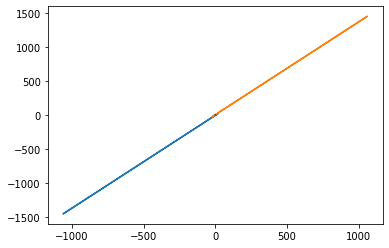

In [16]:
for pts3D in pts3D_4:
    print(pts3D.shape)
    x = pts3D[:,0]
    y = pts3D[:,1]
    plt.plot(x, y)

In [8]:
np.dot(S, R2), E

(array([[-0.01436469, -0.67238415, -0.25949168],
        [ 0.84380403, -0.06920706,  0.51278222],
        [ 0.15586874, -0.67339079, -0.15121706]]),
 array([[ 0.01436469,  0.67238415,  0.25949168],
        [-0.84380403,  0.06920706, -0.51278222],
        [-0.15586874,  0.67339079,  0.15121706]]))

In [9]:
-S[1,2],S[0,2],-S[0,1]

(0.693078125191146, 0.14233599623355478, -0.7066704865478167)

In [11]:
U[:,2]

array([-0.69307813, -0.142336  ,  0.70667049])

In [12]:
t = np.array([-S[1,2],S[0,2],-S[0,1]]).reshape(3,1)

In [16]:
P = np.hstack((R1, t))

In [17]:
P.shape

(3, 4)